In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())

[03/31 04:53:34]


In [2]:
def reproject(params, vertices, distort=False):
    R = params['R']
    t = params['t']
    k1 = params['k1']
    k2 = params['k2']
    k3 = params['k3']
    p1 = params['p1']
    p2 = params['p2']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']
    f = (fx + fy) * 0.5

    E = np.array([
        [R[0,0], R[0,1], R[0,2], t[0]], 
        [R[1,0], R[1,1], R[1,2], t[1]], 
        [R[2,0], R[2,1], R[2,2], t[2]], 
        [0, 0, 0, 1]]).astype('double')

    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = f * xp + cx
        v = f * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

# Load captured images, without resizing it

In [149]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)
target_texturemap_size = 128
# images
img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
mesh_dir = img_dir + '/../'

img_paths = glob.glob(img_dir + '/*.jpg')
image_refs_original = []
for path in img_paths:
    img = imageio.imread(path)
    image_refs_original.append(img)
#     img = cv2.undistort(img, p['M'], p['dist'], None, None)
print('{} images loaded: {}'.format(len(image_refs_original), image_refs_original[0].shape))

16 images loaded: (2160, 4000, 3)


# Load obj mesh and generate texturemaps


In [150]:
# Load obj file
in_path = r'D:\1_Projects\200325_PyTorch3d_Toy\4_data\input\2020_03_28_SMPL_UV\SMPL_registration\SMPLFit_TPose.obj'
# in_path = r'D:\1_Projects\200325_PyTorch3d_Toy\4_data\input\2020_03_28_SMPL_UV\SMPL_Male.obj'
mesh = load_objs_as_meshes([in_path], device=device)

target_texturemap_shape = (target_texturemap_size, target_texturemap_size, 3)
texture_image = torch.from_numpy(np.ones((1, target_texturemap_shape[0], target_texturemap_shape[1], target_texturemap_shape[2])).astype(np.float32)).to(device)
# texture_image = mesh_texture
texture_image0 = mesh.textures.maps_padded()
print('Texturemap size: {}'.format(texture_image.shape))
print('Vertices:', mesh.verts_packed().shape)
print('Faces:', mesh.faces_packed().shape)
print(texture_image.is_cuda)

mesh_vertices = mesh.verts_packed().clone().cpu().numpy()
print(mesh_vertices.shape)

Texturemap size: torch.Size([1, 128, 128, 3])
Vertices: torch.Size([6890, 3])
Faces: torch.Size([13776, 3])
True
(6890, 3)


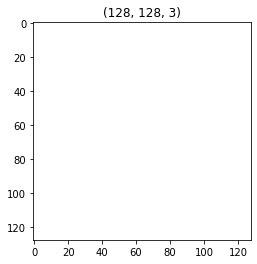

In [151]:
texturemap_np = texture_image.squeeze().cpu().numpy()
plt.imshow(texturemap_np)
plt.title(texturemap_np.shape)
plt.show()

# Load cameras

In [152]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

in_path = r'D:\CalibrationData\CameraCalibration\2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
with open(in_path, 'r') as f:
    j = json.load(f)
    cam_params = j['cam_params']

sensor_size_mm = (22, 11.88)
cameras = []
camera_parameters = []
composed_mtx = []
for cam_idx, cam in enumerate(cams):
    cam_param = cam_params[str(cam_idx)]
    # for undistortion
    fx = cam_param['fx']
    fy = cam_param['fy']
    cx = cam_param['cx']
    cy = cam_param['cy']
    k1 = cam_param['k1']
    k2 = cam_param['k2']
    p1 = cam_param['p1']
    p2 = cam_param['p2']
    k3 = cam_param['k3']
    
    # for undistortion
    M = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    dist = np.array([k1, k2, p1, p2, k3])
    cam_mtx, _ = cv2.getOptimalNewCameraMatrix(M, dist, (4000, 2160), 1, (4000, 2160))
    camera_parameters.append({'M': M, 'dist': dist})

    rvec = np.float32(cam_param['rvec'])
    T = np.float32(cam_param['tvec'])
    R, _ = cv2.Rodrigues(rvec)
    # T = -R.T.dot(T)
    R = R.T

    # R = R.dot(R_z180)
    R_torch = torch.from_numpy(R).unsqueeze(0)
    T_torch = torch.from_numpy(T).unsqueeze(0)
    cam_params[str(cam_idx)]['R'] = R.T
    cam_params[str(cam_idx)]['t'] = T
    
    # cv2.calibrationMatrixValues(cameraMatrix, imageSize, apertureWidth, apertureHeight) → fovx, fovy, focalLength, principalPoint, aspectRatio
    fovx, fovy, focalLength, principalPoint, aspectRatio = cv2.calibrationMatrixValues(M, (4000, 2160), sensor_size_mm[0], sensor_size_mm[1])
    fov_x = 2*math.atan(4000 / (2*fx))*180/np.pi
    fov_y = 2*math.atan(2160 / (2*fy))*180/np.pi
    print('Camera {}'.format(cams[cam_idx]))
#     print('  fov x: {}=={}'.format(fovx, fov_x))
#     print('  fov y: {}=={}'.format(fovy, fov_y))
#     print('  aspectRatio: {}'.format(aspectRatio))

    principal_point = np.array([cx, cy]).astype(np.float32)
    principal_point = torch.from_numpy(principal_point).unsqueeze(0)
    
    # F(mm) = F(pixels) * SensorWidth(mm) / ImageWidth (pixel).
    # focal length in world units
    focal_length = np.array([fx, fy]).astype(np.float32)
#     focal_length[0] = focal_length[0] * sensor_size_mm[0] / 4000
#     focal_length[1] = focal_length[1] * sensor_size_mm[1] / 2160
    focal_length = torch.from_numpy(focal_length).unsqueeze(0)
    cameras.append(SfMPerspectiveCameras(device=device, R=R_torch, T=T_torch, principal_point=principal_point, focal_length=focal_length))
#     cameras.append(OpenGLPerspectiveCameras(device=device, R=R_torch, T=T_torch))
    
    se3 = np.array([[R[0, 0], R[0, 1], R[0, 2], T[0]], [R[1, 0], R[1, 1], R[1, 2], T[1]], [R[2, 0], R[2, 1], R[2, 2], T[2]]]).astype(np.float32)
    composed_mtx.append({'E': se3, 'K': M, 'KE': M.dot(se3)})
R, T = look_at_view_transform(2.7, 0, 180) 
cameras_test = OpenGLPerspectiveCameras(device=device, R=R, T=T)

Camera A
Camera B
Camera C
Camera D
Camera E
Camera F
Camera G
Camera H
Camera I
Camera J
Camera K
Camera L
Camera M
Camera N
Camera O
Camera P


### debugging projections...

<IPython.core.display.Javascript object>


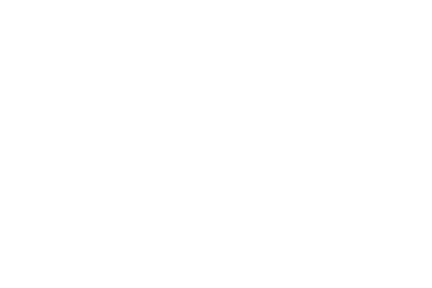

<IPython.core.display.Javascript object>


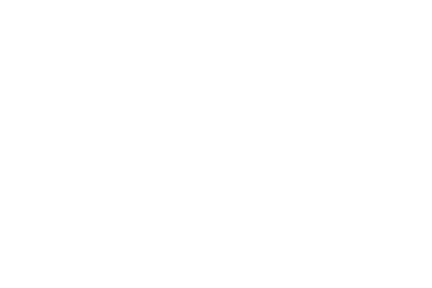

In [153]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(cameras)):
    center = cameras[i].get_camera_center().detach().cpu().numpy()[0]
    ax.scatter(center[0], center[1], center[2])
    ax.set_zlim([0, 2000])
    ax.set_xlim([-3000, 3000])
    ax.set_ylim([-3000, 3000])
    

# Resize and recenter 2160x4000 image

### reprojection of mesh vertices

In [154]:
mesh_points = []
for cam_idx in range(16):
    params = cam_params[str(cam_idx)]
    pts = reproject(params, mesh_vertices, distort=False)
    mesh_points.append(pts)
print(pts.shape)
print(len(mesh_points))

(6890, 2)
16


In [155]:
rendered_image_size = 512

w=1080.0, h=1080.0
1.0


<IPython.core.display.Javascript object>


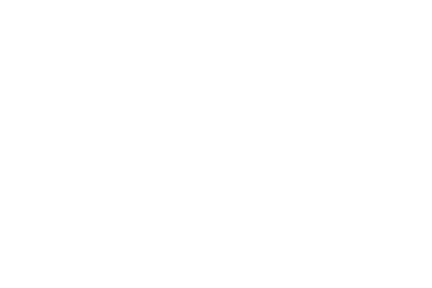

<IPython.core.display.Javascript object>


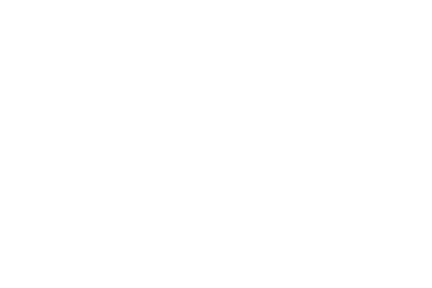

In [156]:
w = 2160/2
h = 2160/2
print('w={}, h={}'.format(w, h))
image_refs = []
for i in range(len(image_refs_original)):
    cam = cam_params[str(i)]
    pts = mesh_points[i]
    image_center = np.mean(pts, axis=0)
#     cx = image_center[0]
#     cy = image_center[1]
    cx = 2000
    cy = 1080
    image = image_refs_original[i]
    img = image[:, int(cx-w):int(cx+w)]
    img = cv2.resize(img, (rendered_image_size, rendered_image_size))
    img = cv2.flip(img, -1)
    img = img / 255.0
    image_refs.append(img)
print(np.max(img))

plt.figure()
plt.imshow(img)
plt.gca().invert_yaxis()

### resh rendering using pytorch3d

In [157]:
raster_settings = RasterizationSettings(
    image_size=rendered_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

renderers = []
for i in range(len(cameras)):
    camera = cameras[i]
    cam_pos = camera.T[0]
    lights = PointLights(device=device, location=[[cam_pos[0], cam_pos[1], cam_pos[2]]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=camera,
            raster_settings=raster_settings
        ),
        shader=TexturedSoftPhongShader(
            device=device, 
            cameras=camera,
            lights=lights
        )
    )
    renderers.append(renderer)
images_rendered = []

print('Rendering:')
for i, renderer in enumerate(renderers):
    print(' {}/{}'.format(i+1, len(renderers)), end='')
    images = renderer(mesh, texture_maps=texture_image)
    pts = mesh_vertices[0:3]
    pts1 = []
    for j in range(pts.shape[0]):
        p = composed_mtx[i]['KE'].dot(np.array([pts[j][0], pts[j][1], pts[j][2], 1]))
        pts1.append(p)
    images = images[0, ..., :3].cpu().numpy()
    images_rendered.append(images)
print()
print('{} images rendered'.format(len(images_rendered)))

Rendering:
 1/16 2/16 3/16 4/16 5/16 6/16 7/16 8/16 9/16 10/16 11/16 12/16 13/16 14/16 15/16 16/16
16 images rendered


<IPython.core.display.Javascript object>


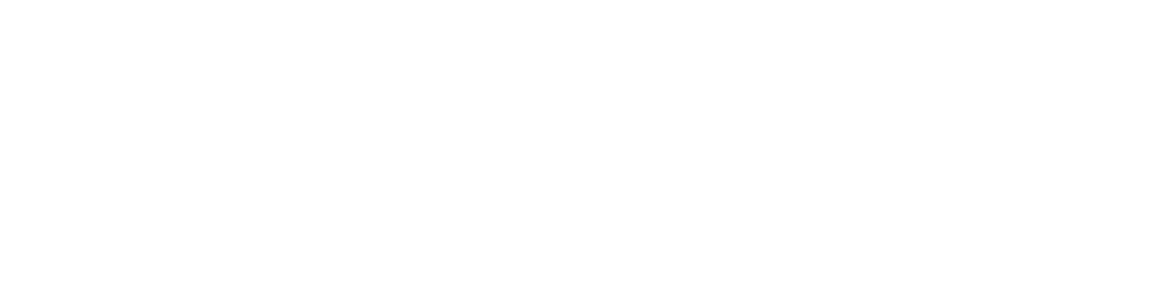

<IPython.core.display.Javascript object>


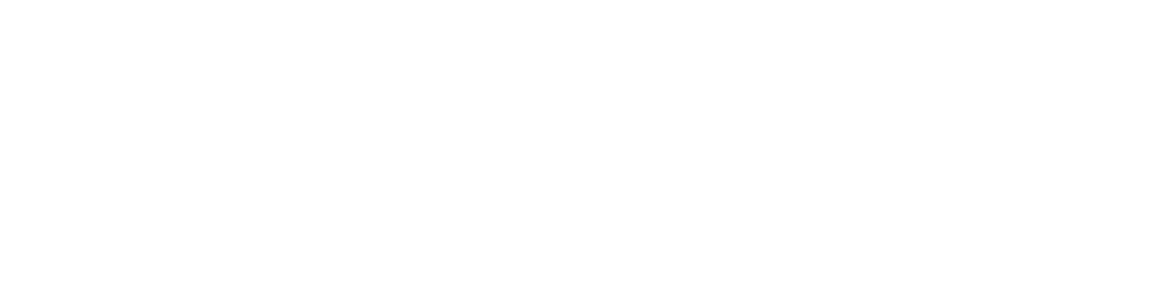

In [158]:
fig, ax = plt.subplots(2, 8, figsize=(16, 4))
ax = ax.ravel()
for i in range(len(ax)):
    a = ax[i]
    img = cv2.flip(images_rendered[i], -1)
    a.imshow(img)
plt.show()

### visualize

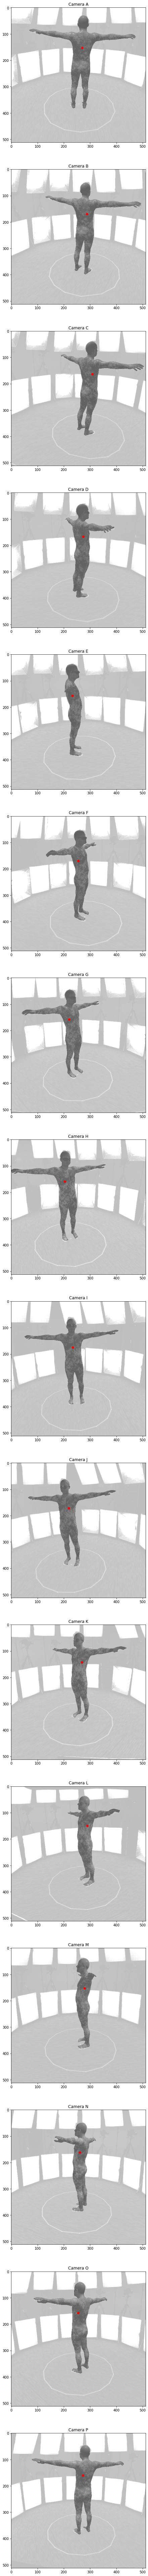

In [160]:
%matplotlib inline
fig, ax = plt.subplots(16, 1, figsize=(15, 140))
ax = ax.ravel()
for i in range(len(ax)):
    img_mesh = images_rendered[i]
    img_mesh = cv2.flip(img_mesh, -1)
    img_bg = image_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    ax[i].imshow(img_bg)

    img_mesh_large = np.zeros(img_bg.shape)
    img_mesh_padded = cv2.copyMakeBorder(img_mesh, 0, 0, int((4000-2160)/2), int((4000-2160)/2), 0, None, [0, 0, 0])
    ax[i].imshow(img_mesh, alpha=0.75)
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts_small_y = pts[:, 1] * rendered_image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='r', s=0.1)
#     ax[i].scatter(pts_small[:, 0], pts_small[:, 1], c='r', s=0.01)
    ax[i].set_title('Camera {}'.format(cams[i]))
    
    # plot centers
    ax[i].scatter(pts_center[0], pts_center[1], c='r')


# Train

In [161]:
class Model(nn.Module):
    def __init__(self, meshes, image_refs, renderers, texture_maps):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderers = renderers
        self.register_buffer('image_refs', image_refs)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.texture_maps = nn.Parameter(texture_maps.clone().to(meshes.device), requires_grad=True)
        
    def forward(self):
        loss = 0
        images = []
        for i in range(len(self.renderers)):
            image = self.renderers[i](meshes_world=self.meshes.clone(), texture_maps=self.texture_maps)
            loss_i = torch.mean((image.squeeze()[..., :3] - self.image_refs[i]) ** 2)
            images.append(image)
            loss = loss + loss_i
        loss /= len(self.renderers)
        return loss, images, self.texture_maps.clone()

In [162]:
def visualize(images, images_ref, save_path):
    assert(len(images) == 16)
    fig, ax = plt.subplots(2, 8, figsize=(15, 4), tight_layout=True)
    ax = ax.ravel()
    
    for i in range(len(images)):
#         img_ref = cv2.flip(images_ref[i], -1)
        img_mesh = cv2.flip(images[i].clone().squeeze().cpu().numpy(), -1)
        
#         ax[i].imshow(img_ref)
        ax[i].imshow(img_mesh)
        
#         ax[i].axis("off")
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.savefig(save_path, dpi=150)
    plt.close('all')
    
# Initialize a model using the renderer, mesh and reference image
image_refs_torch = torch.from_numpy(np.array(image_refs, dtype=np.float32)).to(device)
model = Model(meshes=mesh.clone(), image_refs=image_refs_torch.clone(), renderers=renderers, texture_maps=texture_image).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
loss, images, texels = model()
print(loss)
print('Done')

tensor(0.5565, device='cuda:0', grad_fn=<DivBackward0>)
Done


tensor(0.5565, device='cuda:0', grad_fn=<DivBackward0>)


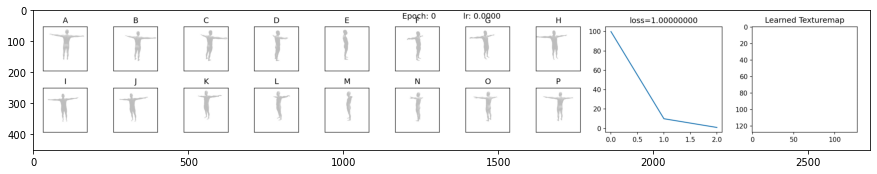

In [163]:
def visualize_LR(e, lr, losses, images, imgR, out_path):
    img_meshes = []
    for i in range(len(images)):
        img_mesh = cv2.flip(images[i].detach().squeeze().cpu().numpy(), -1)
        img_meshes.append(img_mesh)
        
    fig = plt.figure(figsize=(18, 3), tight_layout=True)
    
    gs = fig.add_gridspec(2, 12)
    for r in range(2):
        for c in range(8):
            i = r*8 + c
            ax = fig.add_subplot(gs[r, c])
            ax.set_title('{}'.format(cams[i]))
            ax.imshow((255*img_meshes[i]).astype(np.uint8))
            ax.set_xticks([])
            ax.set_yticks([])
    ax = fig.add_subplot(gs[:, 8:10])
    ax.plot(losses)
    ax.set_title('loss={:.8f}'.format(losses[-1]))
    
    ax = fig.add_subplot(gs[:, 10:12])
    ax.imshow((255*imgR.squeeze()).astype(np.uint8))
    ax.set_title('Learned Texturemap')
    
    plt.suptitle('Epoch: {:<10}  lr: {:<.4f}'.format(e, lr))
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

texels_np = texels.detach().cpu().numpy()
save_path = r'./4_data/output/temp_plot.png'
saved_img = visualize_LR(0, 0, [100, 10, 1], images, texels_np, save_path)
plt.figure(figsize=(15, 3))
plt.imshow(saved_img)
print(loss)

# Init mesh & texturemap

In [164]:
texture_image = torch.from_numpy(np.ones((1, target_texturemap_shape[0], target_texturemap_shape[1], target_texturemap_shape[2])).astype(np.float32)).to(device)
model = Model(meshes=mesh.clone(), image_refs=image_refs_torch.clone(), renderers=renderers, texture_maps=texture_image).to(device)

<ipython-input-165-81d228a7fb10>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(10000))


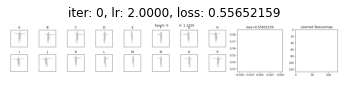

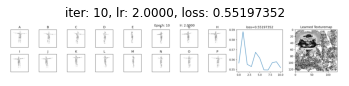

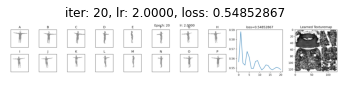

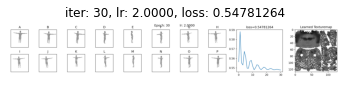

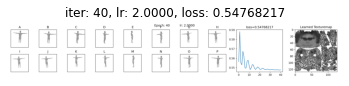

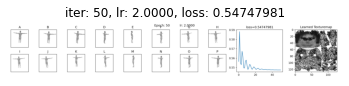

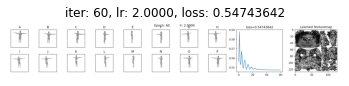

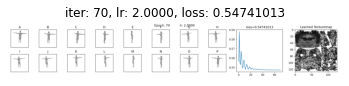

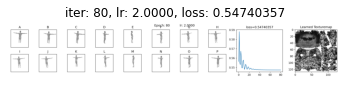

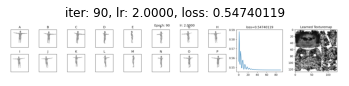

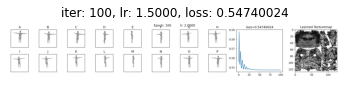

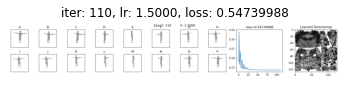

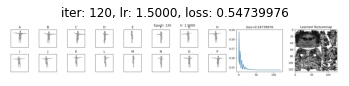

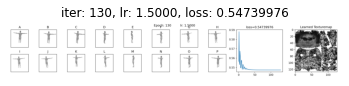

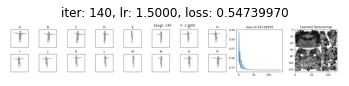

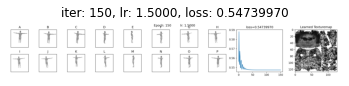

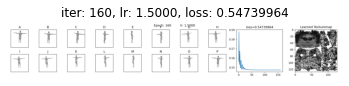

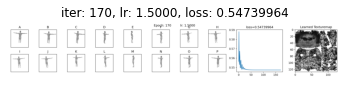

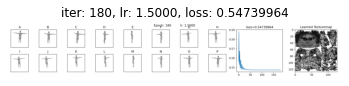

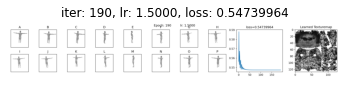

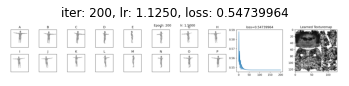

KeyboardInterrupt: 

In [165]:
filename_output = './4_data/output/out.gif'
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

optimizer = torch.optim.Adam(model.parameters(), lr=2.0)

loop = tqdm_notebook(range(10000))

losses = []

for i in loop:
    if i > 0 and i % 100 == 0:
        optimizer.param_groups[0]['lr'] *= 0.75
    
    optimizer.zero_grad()
    loss, images, texels = model()
    # tensor(2498.5450, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
    loss.backward()
    optimizer.step()
    
    loop.set_description('[{}/{}] loss={:.6f}'.format(i, len(loop), loss.data))
    
    losses.append(loss)
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        texels_np = texels.detach().cpu().numpy()
        image_out = visualize_LR(i, lr, losses, images, texels_np, save_path)

        plt.figure()
        plt.imshow(image_out)
        lr = optimizer.param_groups[0]['lr']
        plt.title("iter: %d, lr: %0.4f, loss: %0.8f" % (i, lr, loss.data))
        plt.grid("off")
        plt.axis("off")
        plt.show()
        
        image_out = image_out / 255.0
        image_out = np.clip(image_out, 0, 1)
        image_out = img_as_ubyte(image_out)
        writer.append_data(image_out)
writer.close()

In [166]:
writer.close()

# After traning

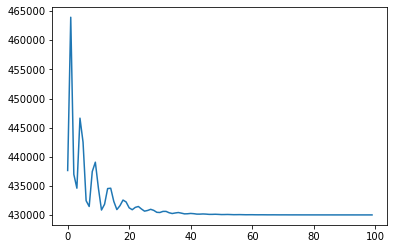

In [43]:
plt.figure()
plt.plot(losses[0:100])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


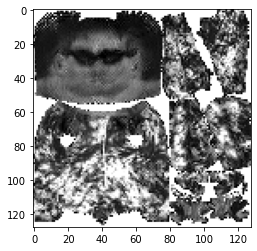

In [167]:
plt.figure()
plt.imshow(model.texture_maps.detach().cpu().numpy()[0, :, :, :])
plt.savefig('./4_data/output/texturemap_learned.png', dpi=600)
plt.show()